# <center>Final Project; Algorithms in Modern Statistics </center>
### Submitted by: 
**<center>Full Names: Matan Mizrachi, Eyal Stolov</center>**

The following project is fully based on the data, that could be found and explained [here](https://www.kaggle.com/kwadwoofosu/predict-test-scores-of-students).

In [108]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, ttest_rel, mannwhitneyu, f_oneway

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
df = pd.read_csv('archive/test_scores.csv')
df['lunch'] = df['lunch'].apply(lambda _z: _z if _z == 'Does not qualify' else 'Qualifies')
df.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,3XOWE,Male,Does not qualify,64.0,76.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,556O0,Female,Does not qualify,61.0,77.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,74LOE,Male,Does not qualify,64.0,76.0


## Part 1: EDA

### Visualizing Categorical Data

In [3]:
df.describe(include='object')

,school,school_setting,school_type,classroom,teaching_method,student_id,gender,lunch
count,2133,2133,2133,2133,2133,2133,2133,2133
unique,23,3,2,97,2,2133,2,2
top,GOOBU,Urban,Public,18K,Standard,PDDSN,Male,Does not qualify
freq,158,906,1582,31,1373,1,1077,1215


Based on the tables above, we can basically dismiss the *student_id* feature, as its variety leads to no valuable information to be gained out of it.

In [4]:
df = df.drop(columns=['student_id'])

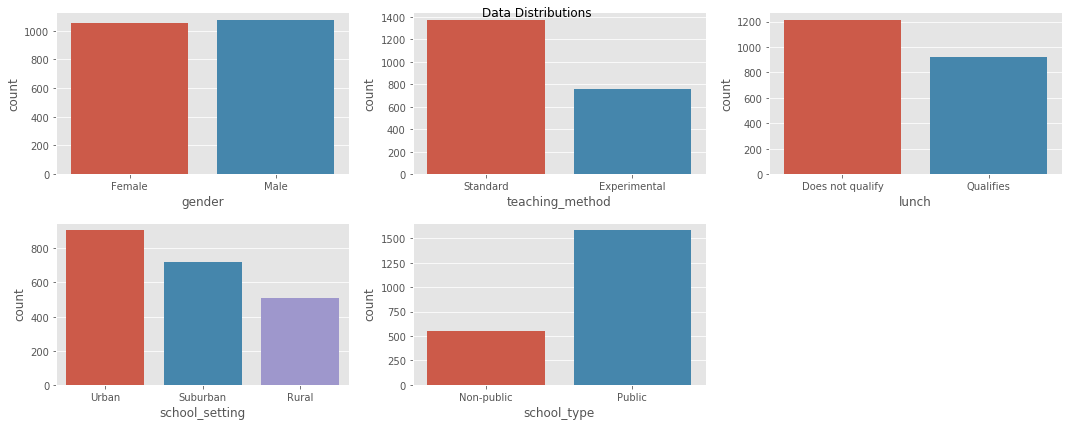

In [5]:
plt.figure(figsize=(15, 6))
plt.suptitle('Data Distributions')
for i, c in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
    plt.subplot(2, 3, i+1)
    sns.countplot(df[c])
plt.tight_layout()
plt.show()

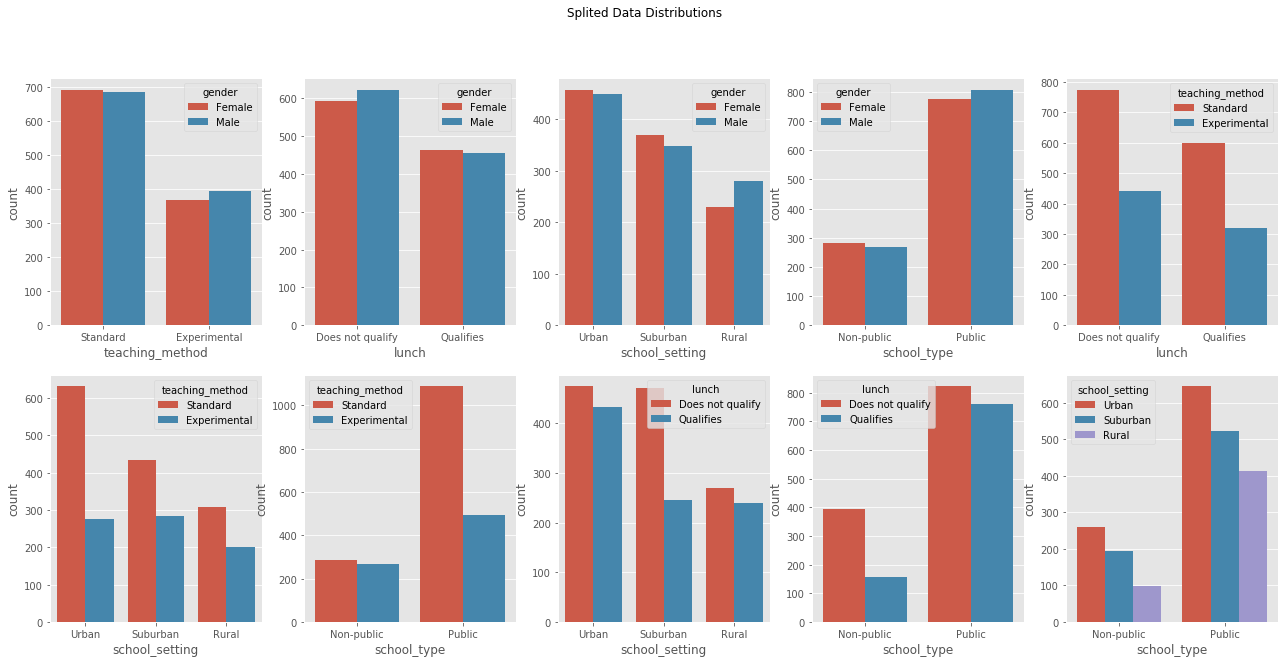

In [6]:
plt.figure(figsize=(22, 10))
plt.suptitle('Splited Data Distributions')
index = 1
for i, hue in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
    for j, col in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
        if j <= i:
            continue
        plt.subplot(2, 5, index)
        index += 1
        sns.countplot(data=df, x=col, hue=hue)
plt.show()

We can already see differences in some of the features distributions when dividing them into separated groups;
- School type, divided by teaching method
- School type, divided by *lunch* feature

### Visualizing Numeric Data

In [7]:
df.describe()

,n_student,pretest,posttest
count,2133.000000,2133.000000,2133.000000
mean,22.796531,54.955931,67.102203
std,4.228893,13.563101,13.986789
min,14.000000,22.000000,32.000000
25%,20.000000,44.000000,56.000000
50%,22.000000,56.000000,68.000000
75%,27.000000,65.000000,77.000000
max,31.000000,93.000000,100.000000


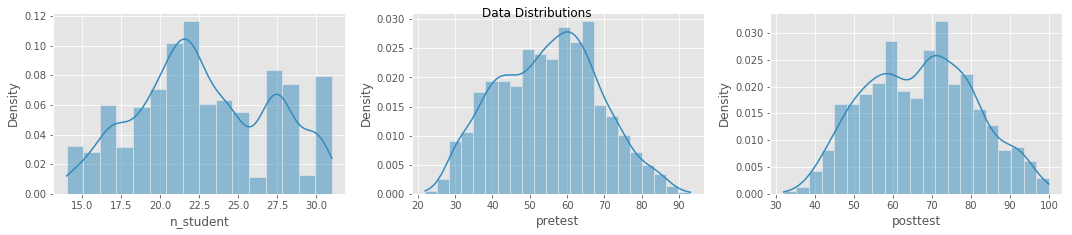

In [8]:
plt.figure(figsize=(15, 6))
plt.suptitle('Data Distributions')
for i, c in enumerate(['n_student', 'pretest', 'posttest']):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df, x=c, kde=True, stat='density', ax=plt.gca())
plt.tight_layout()
plt.show()

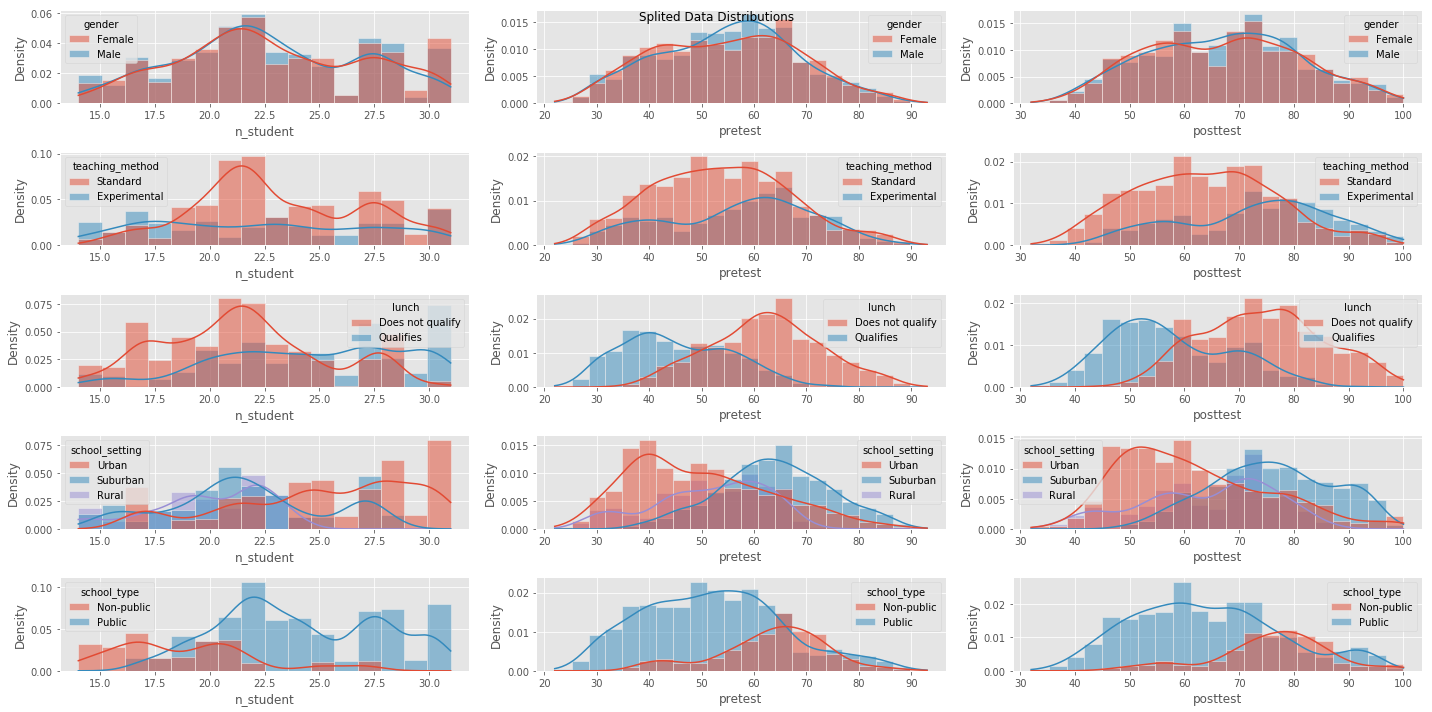

In [9]:
plt.figure(figsize=(20, 10))
plt.suptitle('Splited Data Distributions')
index = 1
for i, hue in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
    for j, col in enumerate(['n_student', 'pretest', 'posttest']):
        plt.subplot(5, 3, index)
        index += 1
        sns.histplot(data=df, x=col, hue=hue, kde=True, stat='density', ax=plt.gca())
plt.tight_layout()
plt.show()

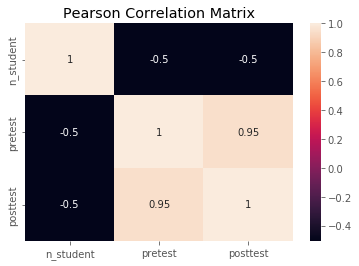

In [10]:
sns.heatmap(df[['n_student', 'pretest', 'posttest']].corr(), annot=True)
plt.title('Pearson Correlation Matrix')
plt.show()

Clearly, the pretest and posttest scores are very highly correlated, almost as if these were the same features to work with.


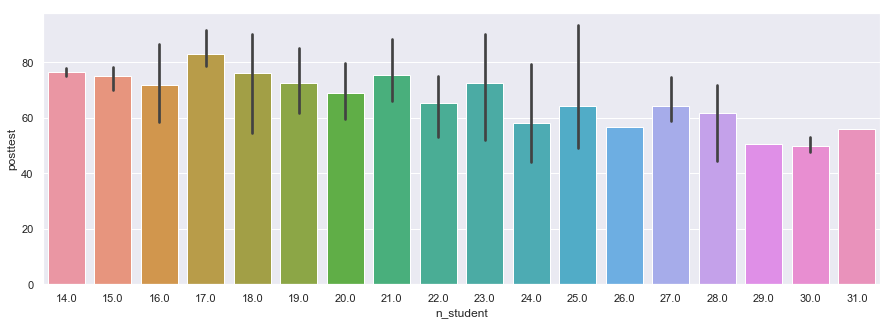

In [11]:
sns.set_theme(rc={'figure.figsize':(15,5)})
sns.barplot(data=df.groupby('classroom').mean(),x='n_student',y='posttest',ci=100)
plt.show()

## Part 2: Hypothesis Testing

Next, we can question whether the differences, of posttest scores, between students that qualifies to free lunch and those that do not, are significant, 

In [79]:
def split_grades(feature):
    if feature=='school_setting':
        a=[]
        b=[]
        c=[]
        
        condition=df.groupby(feature).count().index

        for i in range(df.shape[0]):
            if df.loc[i][feature]==condition[0]:
                a.append(df.loc[i]['posttest'])
            else:
                if df.loc[i][feature]==condition[1]:
                    b.append(df.loc[i]['posttest'])
                else:
                    c.append(df.loc[i]['posttest'])
                    
        a=[condition[0],a]
        b=[condition[1],b]
        c=[condition[2],c]
        
        return a,b,c
        
    else:
        a=[]
        b=[]

        condition=df.groupby(feature).count().index

        for i in range(df.shape[0]):
            if df.loc[i][feature]==condition[0]:
                a.append(df.loc[i]['posttest'])
            else:
                b.append(df.loc[i]['posttest']) 
        
        a=[condition[0],a]
        b=[condition[1],b]
        
        return a,b

In [110]:
check_features=['school_type','teaching_method','gender','lunch']
for i in check_features:
    a,b=split_grades(i)
    print(i,'(',a[0],',',b[0],')',' : ',mannwhitneyu(a[1],b[1]),'\n')
    
a,b,c=split_grades('school_setting')
print('school_setting','(',a[0],',',b[0],')',' : ',mannwhitneyu(a[1],b[1]))
print('school_setting','(',a[0],',',c[0],')',' : ',mannwhitneyu(a[1],c[1]))
print('school_setting','(',c[0],',',b[0],')',' : ',mannwhitneyu(c[1],b[1]))

school_type ( Non-public , Public )  :  MannwhitneyuResult(statistic=208085.5, pvalue=4.379396959105047e-75) 

teaching_method ( Experimental , Standard )  :  MannwhitneyuResult(statistic=325111.5, pvalue=1.5027272495779604e-47) 

gender ( Female , Male )  :  MannwhitneyuResult(statistic=563404.0, pvalue=0.3559352789568585) 

lunch ( Does not qualify , Qualifies )  :  MannwhitneyuResult(statistic=166515.0, pvalue=3.703987327780685e-170) 

school_setting ( Rural , Suburban )  :  MannwhitneyuResult(statistic=90397.0, pvalue=6.3591875951780025e-52)
school_setting ( Rural , Urban )  :  MannwhitneyuResult(statistic=197135.5, pvalue=2.218121937319229e-06)
school_setting ( Urban , Suburban )  :  MannwhitneyuResult(statistic=134683.0, pvalue=9.507035386905277e-92)


In [97]:
check_features=['school_type','teaching_method','gender','lunch']
for i in check_features:
    a,b=split_grades(i)
    print(i,'(',a[0],',',b[0],')',' : ',f_oneway(a[1],b[1]),'\n')
    
a,b,c=split_grades('school_setting')
print('school_setting','(',a[0],',',b[0],')',' : ',f_oneway(a[1],b[1]))
print('school_setting','(',a[0],',',c[0],')',' : ',f_oneway(a[1],c[1]))
print('school_setting','(',c[0],',',b[0],')',' : ',f_oneway(c[1],b[1]))
print('school_setting','(',a[0],',',b[0],',',c[0],')',' : ',f_oneway(a[1],b[1],c[1]))

school_type ( Non-public , Public )  :  F_onewayResult(statistic=346.36982073181076, pvalue=9.375658077323967e-72) 

teaching_method ( Experimental , Standard )  :  F_onewayResult(statistic=231.25681659751112, pvalue=1.1640893397300103e-49) 

gender ( Female , Male )  :  F_onewayResult(statistic=0.10151953331754493, pvalue=0.7500449231811932) 

lunch ( Does not qualify , Qualifies )  :  F_onewayResult(statistic=1188.5615435419354, pvalue=2.2616015547519054e-207) 

school_setting ( Rural , Suburban )  :  F_onewayResult(statistic=324.1528417453372, pvalue=1.7649942637816456e-64)
school_setting ( Rural , Urban )  :  F_onewayResult(statistic=10.119836396166107, pvalue=0.0014986845845742932)
school_setting ( Urban , Suburban )  :  F_onewayResult(statistic=520.1783666609288, pvalue=4.3491372162338055e-100)
school_setting ( Rural , Suburban , Urban )  :  F_onewayResult(statistic=284.6449099827679, pvalue=2.776785026022543e-110)


In [113]:
above_23=[]
less_23=[]

for i in range(df.shape[0]):
    if df.loc[i]['n_student']<24:
        less_23.append(df.loc[i]['posttest'])
    else:
        above_23.append(df.loc[i]['posttest'])

ttest_ind(above_23,less_23)

Ttest_indResult(statistic=-24.237600656795124, pvalue=8.014576614110041e-115)

In [89]:
df.groupby('gender').mean()

,n_student,pretest,posttest
gender,,,
Female,22.878788,54.873106,67.004735
Male,22.715877,55.037140,67.197772


In [105]:
df.groupby('school_type').mean()

,n_student,pretest,posttest
school_type,,,
Non-public,18.869328,63.254083,75.961887
Public,24.164349,52.065740,64.016435


In [91]:
df.groupby('lunch').mean()

,n_student,pretest,posttest
lunch,,,
Does not qualify,21.447737,62.292181,74.375309
Qualifies,24.581699,45.246187,57.476035


In [111]:
df.groupby('school_setting').mean()

,n_student,pretest,posttest
school_setting,,,
Rural,20.015686,51.490196,64.050980
Suburban,21.683403,63.841004,76.037657
Urban,25.242826,49.875276,61.748344
